Suggestion: Run this on https://colab.research.google.com
Google is providing free compute resources and this notebook is quite compute heavy
If you do, you will have to upload the Google News word embeddings and install gensim

In [ ]:
#!pip install gensim

In [15]:
import numpy as np
import json

from gensim.models import KeyedVectors

from keras.models import Model
from keras.layers import (Input,Embedding,LSTM,Dense,Dropout)
from keras.optimizers import Adam
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Load iMBd dataset
# add special padding, start, and out of vocab tokens to vocabulary
pad_value = 0
start_value = 1
oov_value = 2
shift = 3
skip_top = 0 # trim the most frequent words
num_words = None # keep only the most frequent words
max_review_length = 128 # truncate reviews that are too long, keeps training time down from 8 hours -> 1 hour
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words,
                                                      skip_top=skip_top,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=start_value,
                                                      oov_char=oov_value,
                                                      index_from=shift)
if max_review_length:
    x_train = np.array([review[0:max_review_length] for review in x_train])
    x_test = np.array([review[0:max_review_length] for review in x_test])

token_to_int = {tok:i+shift for tok,i in imdb.get_word_index().items()}
token_to_int['-PAD-'] = pad_value
token_to_int['-START-'] = start_value
token_to_int['-OOV-'] = oov_value

int_to_token = {i:tok for tok,i in token_to_int.items()}

vocab_size = len(token_to_int)
train_size = len(x_train)
test_size = len(x_test)

print('Vocab Size:',vocab_size)
print('Train Size:',train_size)
print('Test Size:',test_size)

# Load the Google News embeddings                                                                        
model = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin',binary=True)   
embedding_weights = model.syn0                                                                           
                                                                                                         
# These embeddings need to be tied to the iMDb tokens                                                    
# Step 1: Build a Google News token -> vector index look-up table                                        
# Step 2: Build a vector index -> iMDb integer encoding look-up table                                    
# Step 3: Build an iMDb integer encoding -> vector look-up table                                         
# Step 4: Reconstruct the embedding weight matrix using the iMDb integer encoding                        
                                                                                                         
token_to_vecidx = {tok:i for i,tok in enumerate(model.index2word)} # Step 1                              
vecidx_to_int = {idx:token_to_int[tok] for tok,idx in token_to_vecidx.items() \
                 if token_to_int.get(tok)} # Step 2                                                                   
int_to_vec = {i:embedding_weights[idx] for idx,i in vecidx_to_int.items()} # Step 3                      
                                                                                                         
weights = np.zeros((max(list(int_to_token.keys())),embedding_weights.shape[1]))                          
for i,vec in int_to_vec.items():                                                                         
    weights[i] = vec

Vocab Size: 88587
Train Size: 25000
Test Size: 25000


In [23]:
# since we are one hot encoding each review will have a size of (review_length,vocab_size)
# which is quite large and may eat up too much memory.
# To fix this I will define a generator function that will read the integer encoded reviews
# and feed a mini batch of reviews to the model for training
def data_generator(X,y,batch_size=8,shuffle=True):
    indices = np.arange(len(X))
    last_idx = 0
    while True:
        if shuffle: # shuffle for training
            idxs = np.random.choice(indices,batch_size)
        else: # dont shuffle for testing
            idxs = indices[last_idx:last_idx+batch_size]
        X_mini = X[idxs]
        maxlen = max(list(map(len,X_mini)))
        # each sequence in the batch need to have the same length
        # even though the model can accept sequences of different lengths
        X_mini_pad = sequence.pad_sequences(X_mini,maxlen=maxlen,value=pad_value)
        y_mini = y[idxs]
        
        yield X_mini_pad,y_mini
        
        last_idx += batch_size
        if last_idx >= len(X):
            last_idx = 0

# define a function to convert the integer encoded sequence to text
def decode_review(encoded_review):
    return [int_to_token.get(i,'-OOV') for i in encoded_review]

# Preview a random movie review
np.random.seed(7) # comment out this line to see other reviews
encoded_review = np.random.choice(x_train)
review_text = ' '.join(decode_review(encoded_review))
print(encoded_review)
print('-'*100)
print(review_text)

[1, 4002, 24, 6, 78, 96, 8, 380, 12, 13, 197, 14, 16, 204, 21, 95, 13, 1957, 12, 16, 6, 6574, 7, 4, 5731, 1034, 7, 711, 1991, 13, 115, 219, 711, 1991, 366, 13, 16, 1119, 13, 219, 14, 22, 54, 13, 16, 790, 4, 598, 8526, 7509, 228, 80, 79, 1571, 11, 129, 419, 24, 8, 760, 4, 598, 756, 613, 34, 4, 44889, 14, 9, 4, 249, 1664, 302, 207, 126, 110, 33, 4, 172, 58, 14, 22, 1287, 6, 3942, 9997, 7, 503, 102, 906, 4414, 193, 6, 46425, 5, 140, 8, 1445, 276, 4, 5887, 11, 129, 5215, 5, 25, 28, 5887, 671, 13, 377, 319, 14, 22, 23, 20, 70794, 11645, 34, 3584, 50, 9, 31, 136, 121, 12, 16, 40]
----------------------------------------------------------------------------------------------------
-START- lol not a bad way to start it i thought this was original but then i discovered it was a clone of the 1976 remake of king kong i never saw king kong until i was 15 i saw this film when i was 9 the film's funky disco music will get stuck in your head not to mention the film's theme song by the yetians this is 

In [24]:
# define a model to predict the sentiment of a review
# based on the one-hot-encoding input
# define an additional model to view the intermediate embedding layer of the lstm
# it might be interesting to see how the lstm is emebedding the different reviews
lstm_size = 512

def embedding_model():
    review_input = Input(shape=(None,))
    embedding_layer = Embedding(vocab_size,300,mask_zero=True)
    review_embedding = embedding_layer(review_input)
    lstm_layer = LSTM(lstm_size)
    lstm_output = lstm_layer(review_embedding)
    densor = Dense(1,activation='sigmoid')
    output = densor(lstm_output)
    
    model = Model(review_input,output)
    lstm_model = Model(review_input,lstm_output)
    return model, lstm_model

def pretrained_embedding_model():
    review_input = Input(shape=(None,))
    embedding_layer = Embedding(weights.shape[0],
                                weights.shape[1],
                                weights=[weights],
                                trainable=False,
                                mask_zero=True)
    review_embedding = embedding_layer(review_input)
    lstm_layer = LSTM(lstm_size)
    lstm_output = lstm_layer(review_embedding)
    densor = Dense(1,activation='sigmoid')
    output = densor(lstm_output)
    
    model = Model(review_input,output)
    lstm_model = Model(review_input,lstm_output) # allows you to inspect the hidden LSTM layer
    return model, lstm_model

In [ ]:
# running this cell may crash your notebook
# training the embedding model is very computationaly expensive

# my laptop gpu only has 2GB of memory and fails to train this model
# this model can be trained on my cpu, however each epoch takes ~2 hours
# if your gpu runs out of memory, uncomment the following "with" block and indent appropriately.

batch_size = 128
train_generator = data_generator(x_train,y_train,batch_size=batch_size,shuffle=True)
test_generator = data_generator(x_test,y_test,batch_size=batch_size,shuffle=False)
train_steps = len(x_train)//batch_size+1
test_steps = len(x_test)//batch_size+1
epochs = 4

with tf.device('/cpu:0'):
    embedding_model,lstm_embedding = sentiment_model()
    embedding_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    print(embedding_model.summary())
    

    embedding_model.fit_generator(train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=train_steps,
                            epochs=epochs,
                            validation_steps=test_steps)

    # serialize model to JSON
    model_json = embedding_model.to_json()None
    with open("models/learned_embedding_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    embedding_model.save_weights("models/learned_embedding_model.h5")
    print("Saved model to disk")

    # serialize model to JSON
    model_json = lstm_embedding.to_json()
    with open("models/learned_lstm_embedding.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    lstm_embedding_model.save_weights("models/learned_lstm_embedding.h5")
    print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 300)         26576100  
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1665024   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 28,241,637
Trainable params: 28,241,637
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
196/196 [==============================] - 854s - loss: 0.5331 - acc: 0.7150 - val_loss: 0.4636 - val_acc: 0.7898

Note: The vast majority of the models parameters are for the word embeddings, 26.5M

In [42]:
train_generator = data_generator(np.array(x_train),y_train,batch_size=batch_size,shuffle=True)
test_generator = data_generator(np.array(x_test),y_test,batch_size=batch_size,shuffle=False)
train_steps = len(x_train)//batch_size+1
test_steps = len(x_test)//batch_size+1

#with tf.device('/cpu:0'):
pre_model,pre_lstm_embedding = pretrained_embedding_model()
pre_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
print(pre_model.summary())
    

pre_model.fit_generator(train_generator,
                        validation_data=test_generator,
                        steps_per_epoch=train_steps,
                        epochs=epochs,
                        validation_steps=test_steps)

# serialize model to JSON
model_json = pre_model.to_json()
with open("models/pretrained_embedding_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pre_model.save_weights("models/pretrained_embedding_model.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = pre_lstm_embedding.to_json()
with open("models/pretrained_lstm_embedding.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pre_model.save_weights("models/pretrained_lstm_embedding.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         26576100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 27,146,725
Trainable params: 570,625
Non-trainable params: 26,576,100
_________________________________________________________________
None
Epoch 1/6
196/196 [==============================] - 3042s - loss: 0.5129 - acc: 0.7524 - val_loss: 0.4280 - val_acc: 0.8168

With the training complete I am interested to see the output of the intermediate lstm layers in both models.
These lstm layers are responsible for converting the word embeddings (learned or pretrained) into a set of features that can be used for sentiment classification.

In [43]:
mini_batch_idxs = np.random.choice(np.arange(len(x_test)),1000,replace=False)
mini_batch = x_test[mini_batch_idxs]
sequences = sequence.pad_sequences(mini_batch,maxlen=300,value=pad_value)

lstm_vecs = lstm_embedding.predict(sequences)
pre_lstm_vecs = pre_lstm_embedding.predict(sequences)

In [55]:
kmeans = KMeans(10)
clusters = kmeans.fit_predict(lstm_vecs)
# no need to declare a new kmeans instance, will just re-fit
pre_clusters = kmeans.fit_predict(pre_lstm_vecs)

tsne = TSNE(metric='euclidean',n_iter=500)
proj = tsne.fit_transform(lstm_vecs)
pre_proj = tsne.fit_transform(pre_lstm_vecs)

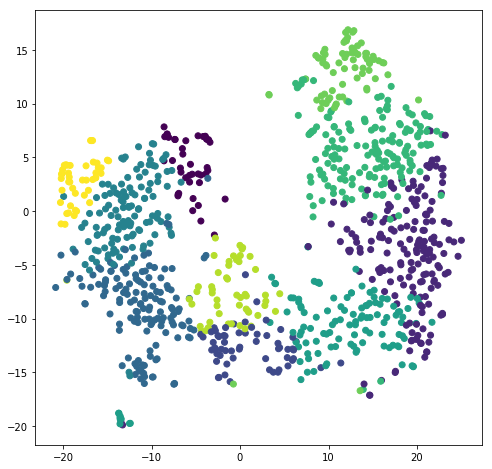

In [57]:
plt.figure(figsize=(8,8))
plt.title('iMDb Reviews for Learned Word Embeddings')
plt.scatter(proj[:,0],proj[:,1],c=clusters,cmap=plt.cm.get_cmap('viridis'))
plt.savefig('../../mike-a-yen.github.io/assets/images/imdb_review_embeddings.png')

In [ ]:
plt.figure(figsize=(8,8))
plt.title('iMDb Reviews for Learned Word Embeddings')
plt.scatter(pre_proj[:,0],pre_proj[:,1],c=clusters,cmap=plt.cm.get_cmap('viridis'))
plt.savefig('../../mike-a-yen.github.io/assets/images/imdb_review_embeddings_pretrained.png')

In [62]:
print('Cluster    True Sentiment    Predicted Sentiment    Population Size')
space = '    '
for cluster_label in range(max(clusters)+1):
    cluster_sequences = sequences[clusters==cluster_label]
    cluster_sentiment = y_test[mini_batch_idxs][clusters==cluster_label]
    predict_sentiment = pre_model.predict(cluster_sequences)
    cluster_reviews = [' '.join([int_to_token[i] for i in encoded if i not in {start_value,pad_value}]) for encoded in cluster_sequences]
    mu = np.mean(cluster_sentiment)
    s = np.std(cluster_sentiment)
    p_mu = np.mean(predict_sentiment)
    print(cluster_label,space*4,'%0.2f'%(100*mu),space*4,'%0.2f'%(100*p_mu),space*4,len(cluster_sentiment))
    #print(cluster_label,':','True Sentiment: %0.2f   Predicted Sentiment: %0.2f'%(100*mu,100*p_mu),'   Cluster Size:',len(cluster_sentiment))

Cluster    True Sentiment    Predicted Sentiment    Population Size
0                  88.10                  77.19                  42
1                  19.21                  30.21                  177
2                  56.67                  47.96                  60
3                  84.51                  70.75                  142
4                  94.31                  79.55                  123
5                  42.02                  42.59                  119
6                  9.52                  22.13                  168
7                  0.00                  13.18                  74
8                  70.59                  65.96                  51
9                  100.00                  88.60                  44


In [35]:
predictions = (pre_model.predict(sequences).ravel()>0.5).astype(int)
true_labels = y_test[mini_batch_idxs]
correct = true_labels==predictions

kmeans = KMeans(10)
clusters = kmeans.fit_predict(lstm_vecs[correct])

tsne = TSNE(metric='cosine')
proj = tsne.fit_transform(lstm_vecs)

print('Cluster\tTrue Sentiment\tPredicted Sentiment\tPopulation Size')
for cluster_label in range(max(clusters)+1):
    cluster_sequences = sequences[clusters==cluster_label]
    cluster_sentiment = y_test[mini_batch_idxs][clusters==cluster_label]
    predict_sentiment = pre_model.predict(cluster_sequences)
    correct = cluster_sentiment==predict_sentiment
    cluster_reviews = [' '.join([int_to_token[i] for i in encoded if i not in {start_value,pad_value}]) for encoded in cluster_sequences]
    mu = np.mean(cluster_sentiment)
    s = np.std(cluster_sentiment)
    p_mu = np.mean(predict_sentiment)
    print(cluster_label,'\t\t','%0.2f\t\t%0.2f\t\t'%(100*mu,100*p_mu),len(cluster_sentiment))

0.9125